In [26]:
import pandas as pd

### Loading and inspecting

In [27]:
# Load the datasets
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

In [28]:
# Inspect the datasets
print(movies.head())
print(ratings.head())

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
   userId  movieId  rating   timestamp
0       1      296     5.0  1147880044
1       1      306     3.5  1147868817
2       1      307     5.0  1147868828
3       1      665     5.0  1147878820
4       1      899     3.5  1147868510


### Data preprocessing

In [29]:
# Merge datasets
data = pd.merge(ratings, movies, on='movieId')

In [30]:
# Sample data
data.head()

,userId,movieId,rating,timestamp,title,genres
0,1,296,5.0,1147880044,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
1,1,306,3.5,1147868817,Three Colors: Red (Trois couleurs: Rouge) (1994),Drama
2,1,307,5.0,1147868828,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama
3,1,665,5.0,1147878820,Underground (1995),Comedy|Drama|War
4,1,899,3.5,1147868510,Singin' in the Rain (1952),Comedy|Musical|Romance


In [31]:
# Check for missing values
print(data.isnull().sum())

userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
dtype: int64


### Exploratory data analysis

<Axes: xlabel='rating'>

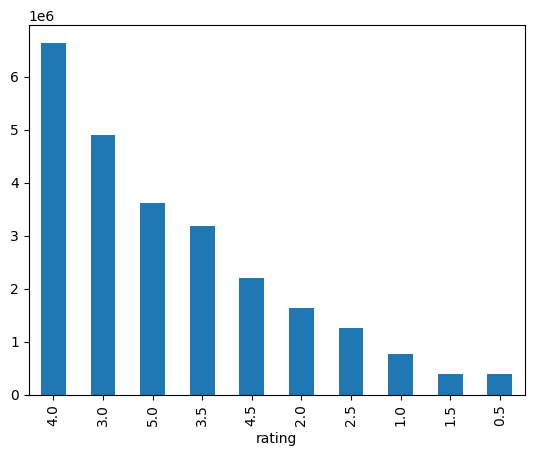

In [32]:
# Distribution of ratings
data['rating'].value_counts().plot(kind='bar')

In [33]:
# Most popular movies
popular_movies = data.groupby('title').size().sort_values(ascending=False).head(10)
popular_movies.head()

title
Forrest Gump (1994)                 81491
Shawshank Redemption, The (1994)    81482
Pulp Fiction (1994)                 79672
Silence of the Lambs, The (1991)    74127
Matrix, The (1999)                  72674
dtype: int64

### Build the recommender system

### BELOW METHOD OF PIVOT CREATION TAKES REQUIRES MORE MEMORY AND FAIL ON 64G MACHINE.

In [34]:
# user_movie_matrix = data.pivot_table(index='userId', columns='title', values='rating')

### Lets use dask to adjust the memory needs

In [35]:
! pip install dask

In [36]:
import dask.dataframe as dd

In [37]:
# Loading with using dask
ratings = dd.read_csv('ratings.csv')
movies = dd.read_csv('movies.csv')

# Merge datasets
data = dd.merge(ratings, movies, on='movieId')
data.head()


,userId,movieId,rating,timestamp,title,genres
0,1,296,5.0,1147880044,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
1,1,306,3.5,1147868817,Three Colors: Red (Trois couleurs: Rouge) (1994),Drama
2,1,307,5.0,1147868828,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama
3,1,665,5.0,1147878820,Underground (1995),Comedy|Drama|War
4,1,899,3.5,1147868510,Singin' in the Rain (1952),Comedy|Musical|Romance


#### Convert 'title' to category dtype

In [38]:
data['title'] = data['title'].astype('category').cat.as_known()

2024-06-26 09:23:08,801 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle ac68c446ef0c1a696e92970b9805aa9d initialized by task ('shuffle-transfer-ac68c446ef0c1a696e92970b9805aa9d', 6) executed on worker tcp://127.0.0.1:34043
2024-06-26 09:23:09,711 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle ac68c446ef0c1a696e92970b9805aa9d deactivated due to stimulus 'task-finished-1719373989.709692'


### DONOT EXECUTE THE BELOW PIVOT CREATION. IT WILL TAKE DOWN THE SYSTEM

In [39]:
# Create a pivot table
# user_movie_matrix = data.pivot_table(index='userId', columns='title', values='rating').compute()

### Using dask in distributed mode 

In [40]:
! pip install dask distributed

In [41]:
import dask.dataframe as dd
from dask.distributed import Client
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import dask_ml.metrics

In [42]:
# Start a sask client
client = Client(n_workers=4, threads_per_worker=8, memory_limit='8GB')

/home/ravik/src_git/LP/env/lib64/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43965 instead
  warnings.warn(


In [43]:
# load the data with dask
movies = dd.read_csv('movies.csv')
ratings = dd.read_csv('ratings.csv')

In [44]:
# merge datasets
data = dd.merge(movies, ratings, on='movieId')

In [45]:
# Convert 'title' to Category Dtype and Set Known Categories
data['title'] = data['title'].astype('category').cat.as_known()

2024-06-26 09:23:14,095 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 432c92aeb648301c6b965ecde8103380 initialized by task ('shuffle-transfer-432c92aeb648301c6b965ecde8103380', 8) executed on worker tcp://127.0.0.1:38937
2024-06-26 09:23:14,720 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 432c92aeb648301c6b965ecde8103380 deactivated due to stimulus 'task-finished-1719373994.7171013'
2024-06-26 09:23:25,199 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:38937 (pid=42568) exceeded 95% memory budget. Restarting...
2024-06-26 09:23:25,367 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:38937' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('read_csv-fused-assign-0968dffa12bfe270319462c6c2bf95ae', 7), ('read_csv-fused-assign-0968dffa12bfe270319462c6c2bf95ae', 6)} (stimulus_id='handle-worker-cleanup-1719374005.3668325')
2024-06-26 09:23:25,480 - distributed.nanny.memory - WARNING - Wor

In [46]:
# Create a pivot table in chunks
user_movie_matrix = data.pivot_table(index='userId', columns='title', values='rating').persist()

In [47]:
user_movie_matrix.head()

2024-06-26 09:23:37,380 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:33409
Traceback (most recent call last):
  File "/home/ravik/src_git/LP/env/lib64/python3.12/site-packages/distributed/comm/tcp.py", line 230, in read
    buffer = await read_bytes_rw(stream, buffer_nbytes)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ravik/src_git/LP/env/lib64/python3.12/site-packages/distributed/comm/tcp.py", line 366, in read_bytes_rw
    actual = await stream.read_into(chunk)  # type: ignore[arg-type]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ravik/src_git/LP/env/lib64/python3.12/site-packages/distributed/worker.py", line 2058, in gather_dep
    response = await get_data_from_worker(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ravik/src_git/LP/env

KilledWorker: Attempted to run task ('pivot_sum-885296ada7fd580a647e07f530a58cad', 9) on 4 different workers, but all those workers died while running it. The last worker that attempt to run the task was tcp://127.0.0.1:39073. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.

2024-06-26 09:23:49,315 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:39073
Traceback (most recent call last):
  File "/home/ravik/src_git/LP/env/lib64/python3.12/site-packages/distributed/comm/tcp.py", line 227, in read
    frames_nosplit = await read_bytes_rw(stream, frames_nosplit_nbytes)
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ravik/src_git/LP/env/lib64/python3.12/site-packages/distributed/comm/tcp.py", line 366, in read_bytes_rw
    actual = await stream.read_into(chunk)  # type: ignore[arg-type]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ravik/src_git/LP/env/lib64/python3.12/site-packages/distributed/worker.py", line 2058, in gather_dep
    response = await get_data_from_worker(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  